In [2]:
# Tools
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results = 2, doc_content_chars_max = 2000)
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
print(arxiv.invoke("mixture of experts"))

Published: 2018-06-21
Title: Mixtures of Experts Models
Authors: Isobel Claire Gormley, Sylvia Frühwirth-Schnatter
Summary: Mixtures of experts models provide a framework in which covariates may be
included in mixture models. This is achieved by modelling the parameters of the
mixture model as functions of the concomitant covariates. Given their mixture
model foundation, mixtures of experts models possess a diverse range of
analytic uses, from clustering observations to capturing parameter
heterogeneity in cross-sectional data. This chapter focuses on delineating the
mixture of experts modelling framework and demonstrates the utility and
flexibility of mixtures of experts models as an analytic tool.

Published: 2014-03-09
Title: Learning Factored Representations in a Deep Mixture of Experts
Authors: David Eigen, Marc'Aurelio Ranzato, Ilya Sutskever
Summary: Mixtures of Experts combine the outputs of several "expert" networks, each of
which specializes in a different part of the input s

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results = 1, doc_content_chars_max = 2000)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
wiki.name

'wikipedia'

In [6]:
print(wiki.invoke("mixture of experts"))

Page: Mixture of experts
Summary: Mixture of experts (MoE) is a machine learning technique where multiple expert networks (learners) are used to divide a problem space into homogeneous regions. MoE represents a form of ensemble learning. They were also called committee machines.




In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()
print(tavily.invoke("MoE usage in gpt oss"))

C:\Users\akash\AppData\Local\Temp\ipykernel_17668\513999119.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


[{'title': 'Lessons learned while building GPT-OSS from scratch : r/LocalLLaMA', 'url': 'https://www.reddit.com/r/LocalLLaMA/comments/1mpgj7u/lessons_learned_while_building_gptoss_from_scratch/', 'content': '5.   Mixture‑of‑Experts (MoE) replaces a single feed‑forward module I experimented with MoE blocks to route tokens to specific experts per layer. That’s exactly what gpt‑oss does. It uses a Mixture-of-Experts (MoE)layer instead of a single feed-forward module, activating a small subset of specialized experts per token to improve efficiency and scalability without increasing compute for every input. [...] I’m still early in the process, there are efficiency, tokenizer, and training-duration bottlenecks. I plan to refine attention mechanisms, optimize memory usage, and possibly integrate MoE routing more carefully.\n\nFeedback and collaboration welcome!\n\nIf you have suggestions, want to submit a bug, or open a pull request, here is the repo \n\nExample output\n\n`python src/generat

In [9]:
# Combine tools

tools = [arxiv, wiki, tavily]

In [10]:
# Initialize the LLM

from langchain_groq import ChatGroq

llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [11]:
llm.invoke("what is Mixture of experts")

AIMessage(content='<think>\nOkay, so I\'m trying to understand what a Mixture of Experts is. I\'ve heard the term before in the context of machine learning, but I\'m not entirely sure what it means. Let me start by breaking down the name. "Mixture" suggests that it\'s a combination of something, and "Experts" implies that these are specialized components. So maybe it\'s a model that combines several specialized models?\n\nI remember that in machine learning, sometimes models can be combined to improve performance. Like ensemble methods such as bagging or boosting. But Mixture of Experts sounds a bit different. Maybe it\'s about dividing the problem into smaller parts and having each part handled by a specialist?\n\nI think I\'ve heard about the idea of different "experts" handling different regions of the data. So perhaps each expert is a model that\'s really good at a specific subset of the data, and then some gating mechanism decides which expert should handle which part. That makes 

In [12]:
llm_with_tools = llm.bind_tools(tools = tools)

In [14]:
llm_with_tools.invoke("what is the latest news on AI")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user asked, "what is the latest news on AI." I need to figure out the best way to assist them using the tools I have.\n\nFirst, I should consider the tools available: arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is great for academic papers, so if the user wanted the latest research, that would be perfect. But they\'re asking for news, which is more current events. \n\nWikipedia is good for general information but might not have the latest updates since it\'s not a news source. \n\nTavily_search_results_json is a search engine optimized for current events, so it\'s the most appropriate here. It can provide up-to-date information from various sources.\n\nI should use tavily_search_results_json with the query "latest news on AI" to get relevant and recent results. That should give the user the information they\'re looking for.\n', 'tool_calls': [{'id': 'hygyza517', 'function': {'arguments': '{"quer

# Workflow

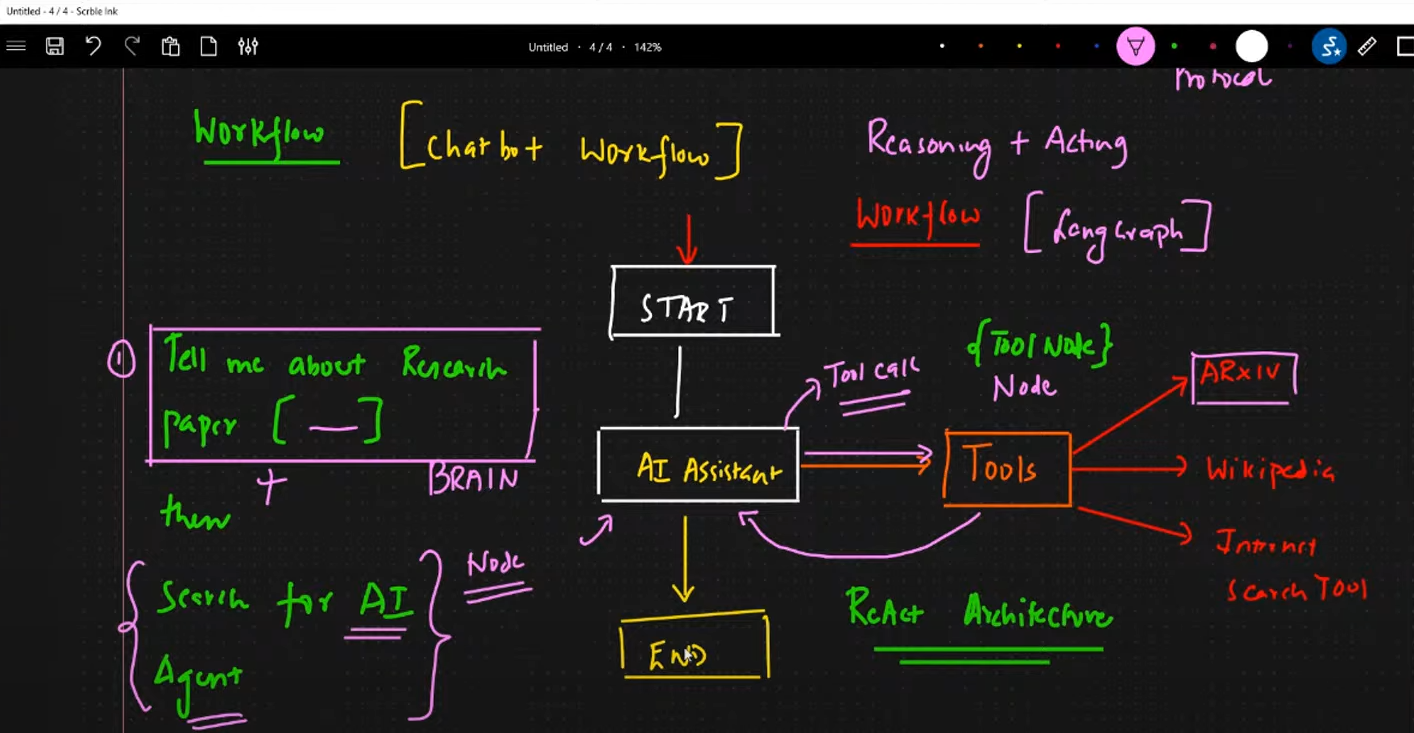

In [15]:
# State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # Human message or AI message
from typing import Annotated # Labelling
from langgraph.graph.message import add_messages # reducers in langgraph


In [16]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [17]:
# Libraries for Langgraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [31]:
# Node Definition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Build the graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph_builder = builder.compile()

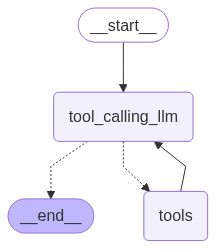

In [32]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [38]:
from langchain_core.messages import HumanMessage

messages = graph_builder.invoke({"messages": HumanMessage(content="What is the most important recent research paper for generative AI")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the most important recent research paper for generative AI
================================== Ai Message ==================================
Tool Calls:
  arxiv (cfdxny8x8)
 Call ID: cfdxny8x8
  Args:
    query: generative AI recent research paper
================================= Tool Message =================================
Name: arxiv

Published: 2021-03-29
Title: "Weak AI" is Likely to Never Become "Strong AI", So What is its Greatest Value for us?
Authors: Bin Liu
Summary: AI has surpassed humans across a variety of tasks such as image
classification, playing games (e.g., go, "Starcraft" and poker), and protein
structure prediction. However, at the same time, AI is also bearing serious
controversies. Many researchers argue that little substantial progress has been
made for AI in recent decades. In this paper, the author (1) explains why
controversies about AI exist; (2) discriminates two para